In [102]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go


from cointegration.cointegration_system import CointegrationTradingSystem
from cointegration.cointegration_optimization import OptimizeCointegrationTradingSystem

In [103]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [104]:
%%R
# Install required packages
if (require("dplyr") == FALSE) {
  install.packages("dplyr")
  library(dplyr)
}
if (require("zoo") == FALSE) {
  install.packages("zoo")
  library(zoo)
}

if (require("forecast") == FALSE) {
  install.packages("forecast")
  library(forecast)
}
if (require("tseries") == FALSE) {
  install.packages("tseries")
  library(tseries)
}
if (require("moments") == FALSE) {
  install.packages("moments")
  library(moments)
}
if (require("tibble") == FALSE) {
  install.packages("tibble")
  library(tibble)
}
if (require("urca") == FALSE) {
  install.packages("urca")
  library(urca)
}
if (require("tsDyn") == FALSE) {
  install.packages("tsDyn")
  library(tsDyn)
}
if (require("strucchange") == FALSE) {
  install.packages("strucchange")
  library(strucchange)
}

In [105]:
hub1_name = "ttf"
hub2_name = "nbp"
validation_size = 250
test_size = 250
window_size = 5

In [106]:
%R -i hub1_name
%R -i hub2_name
%R -i validation_size
%R -i test_size

In [107]:
%%R
hubs <- list(
    "nbp" = read.csv("../data/interpolated/nbp_close_interpolated.csv"),
    "peg" = read.csv("../data/interpolated/peg_close_interpolated.csv"),
    "the" = read.csv("../data/interpolated/the_close_interpolated.csv"),
    "ttf" = read.csv("../data/interpolated/ttf_close_interpolated.csv"),
    "ztp" = read.csv("../data/interpolated/ztp_close_interpolated.csv")
)


In [108]:
%%R
hub1 <- hubs[[hub1_name]]
hub2 <- hubs[[hub2_name]]

aics <- c()
bics <- c()



hubs <- data.frame(hub1 = hub1$CLOSE, hub2 = hub2$CLOSE)

train_size <- nrow(hubs) - test_size + 1
train <- hubs[1:train_size,]
max_lag <- 20
for (p in 1:max_lag) {
vecm <- VECM(train, lag = p,  r = 1, include = "const", estim = "ML")
aics <- c(aics, AIC(vecm))
bics <- c(bics, BIC(vecm))
}
lags <- which.min(bics)
print(lags)


jotest <- ca.jo(train, type="trace", ecdet="none", spec="transitory", K = lags)

summary(jotest)

[1] 5

###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.015041532 0.003126657

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 |  4.04  6.50  8.18 11.65
r = 0  | 23.61 15.66 17.95 23.52

Eigenvectors, normalised to first column:
(These are the cointegration relations)

          hub1.l1    hub2.l1
hub1.l1  1.000000  1.0000000
hub2.l1 -1.401604 -0.6917516

Weights W:
(This is the loading matrix)

          hub1.l1      hub2.l1
hub1.d 0.02562707 -0.010947644
hub2.d 0.04280174 -0.007456845




	 Optimal (m+1)-segment partition: 

Call:
breakpoints.formula(formula = hub1 ~ hub2, data = hubs)

Breakpoints at observation number:
                            
m = 1               920     
m = 2               920 1151
m = 3           614 920 1151
m = 4   308     609 920 1151
m = 5   231 462 693 924 1155

Corresponding to breakdates:
                                                                               
m = 1                                                         0.59546925566343 
m = 2                                                         0.59546925566343 
m = 3                                       0.397411003236246 0.59546925566343 
m = 4   0.199352750809061                   0.394174757281553 0.59546925566343 
m = 5   0.149514563106796 0.299029126213592 0.448543689320388 0.598058252427184
                         
m = 1                    
m = 2   0.744983818770227
m = 3   0.744983818770227
m = 4   0.744983818770227
m = 5   0.747572815533981

Fit:
                  

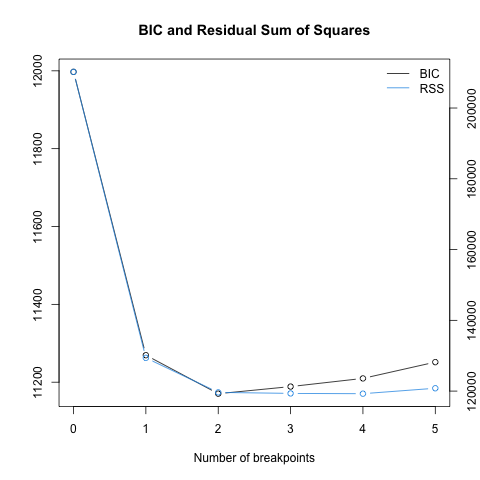

In [109]:
%%R

# Fit a linear model for structural break analysis
bp_test <- breakpoints(hub1 ~ hub2, data = hubs)

# Plot the breakpoints
plot(bp_test)

# Summarize the results to see breakpoints
summary(bp_test)


In [111]:
%%R
breaks <- breakpoints(bp_test)$breakpoints
# Assuming your data is in a data frame called `hubs`
segment1 <- hubs[1:breaks[1], ]
segment2 <- hubs[(breaks[1] + 1):breaks[2], ]
segment3 <- hubs[(breaks[2] + 1):nrow(hubs), ]

model1 <- lm(hub1 ~ hub2, data = segment1)
model2 <- lm(hub1 ~ hub2, data = segment2)
model3 <- lm(hub1 ~ hub2, data = segment3)


In [112]:
%%R
breaks

[1]  920 1151


In [113]:
%%R
summary(model1)$coefficients




              Estimate  Std. Error    t value    Pr(>|t|)
(Intercept) -0.4488016 0.060900161  -7.369464 3.81801e-13
hub2         1.0124679 0.001384775 731.142336 0.00000e+00


In [114]:
%%R
summary(model2)$coefficients


            Estimate Std. Error    t value     Pr(>|t|)
(Intercept) 2.395334 3.82832995  0.6256864 5.321437e-01
hub2        1.286095 0.03575366 35.9709853 3.479407e-96


In [115]:
%%R
summary(model3)$coefficients

             Estimate  Std. Error    t value      Pr(>|t|)
(Intercept) 0.9204687 0.277432297   3.317814  9.920434e-04
hub2        1.0033259 0.008010353 125.253634 2.883051e-318


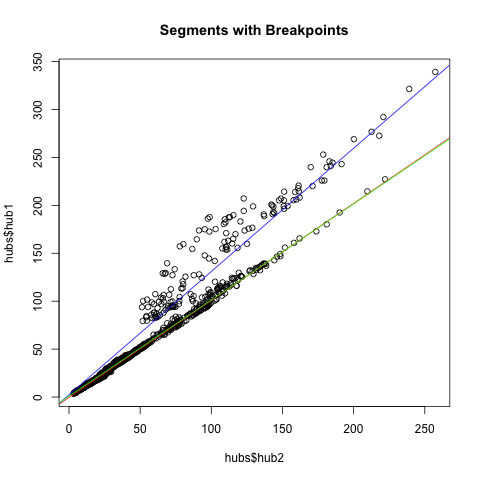

In [116]:
%%R
plot(hubs$hub2, hubs$hub1, main = "Segments with Breakpoints")
abline(model1, col = "red")
abline(model2, col = "blue")
abline(model3, col = "green")



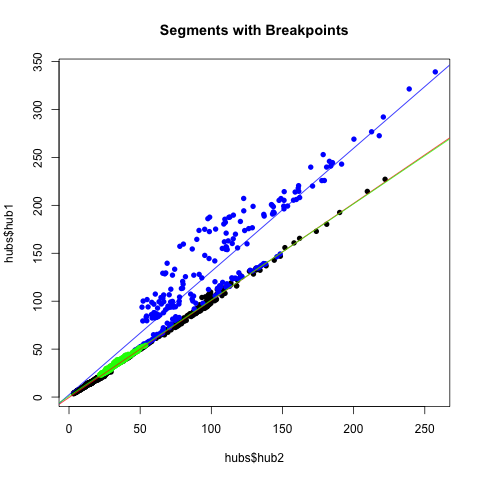

In [118]:
%%R
hubs$segment <- ifelse(1:nrow(hubs) <= breaks[1], "Segment 1",
                       ifelse(1:nrow(hubs) <= breaks[2], "Segment 2", "Segment 3"))

# Assign colors to each segment, with a default color for error-checking
hubs$color <- ifelse(hubs$segment == "Segment 1", "black",
                     ifelse(hubs$segment == "Segment 2", "blue",
                            ifelse(hubs$segment == "Segment 3", "green", "black")))

# Check for any points with unexpected colors
table(hubs$color)

# Plot again to ensure all points are assigned a color
plot(hubs$hub2, hubs$hub1, col = hubs$color, pch = 16, main = "Segments with Breakpoints")
abline(model1, col = "red")
abline(model2, col = "blue")
abline(model3, col = "green")


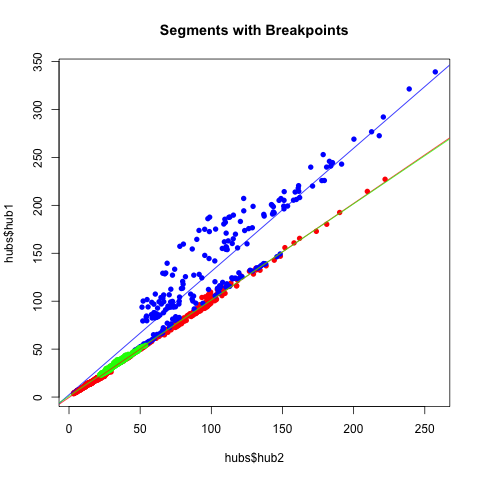

In [35]:
%%R
plot(hubs$hub2, hubs$hub1, col = hubs$color, pch = 16, main = "Segments with Breakpoints")
abline(model1, col = "red")
abline(model2, col = "blue")
abline(model3, col = "green")



In [28]:
%%R
sum(is.na(hub1))
#sum(is.na(hub2))


[1] 0


In [19]:
%%R
hub1[920,]

          Date   CLOSE
920 2022-04-08 103.882


In [20]:
%%R
hub2[1151,]

           Date    CLOSE
1151 2023-02-27 45.84919


In [9]:
%%R

#hs <- tsDyn:::TVECM.HStest(train, lag = lags, ngridTh = 100)


NULL


In [10]:
%%R
#summary(hs)

NULL


In [11]:
%%R
beta = (-1) * jotest@V[2,1]

In [12]:
%R -o beta

In [13]:
hub1 = pd.read_csv("../data/interpolated/" + hub1_name + "_close_interpolated.csv")
hub2 = pd.read_csv("../data/interpolated/" + hub2_name + "_close_interpolated.csv")


In [51]:
octs = OptimizeCointegrationTradingSystem(hub1_name, hub2_name, beta.item(), validation_size, test_size, window_size)

In [52]:
est_profit, best_rolling_window, best_lower_threshold, best_upper_threshold = octs.study(rolling_window_range=[5,60,5], 
                                                                                         lower_threshold_range=[0.5,2,0.02], 
                                                                                         upper_threshold_range=[100,101,1], 
                                                                                         criteria="profit", 
                                                                                         min_trades=10, 
                                                                                         verbose=True, 
                                                                                         plot=True)

Best rolling window: 45.00, Best lower threshold: 1.66, Best upper threshold: 100.00
Profit: 256.48

Mean returns: 0.98%
Standard deviation of returns: 0.05%
Sharpe ratio: 21.02
Mean returns with transaction costs: 0.74%
Confidence interval (returns): 0.40% - 1.56%
Confidence interval (returns with transaction costs): 0.31% - 1.16%

Win rate for returns: 14.00%
No trade rate for returns: 78.80%
Loss rate for returns: 7.20%

Win rate for returns with transaction costs: 17.20%
No trade rate for returns with transaction costs: 78.80%
Loss rate for returns with transaction costs: 4.00%


In [53]:
cts = CointegrationTradingSystem(hub1_name, hub2_name, beta.item(), test_size, window_size)

In [54]:
cts.run_trading_system(rolling_window=best_rolling_window, lower_threshold=best_lower_threshold, upper_threshold=best_upper_threshold, verbose=True, plot=True)

Profit: 20.93

Mean returns: 0.25%
Standard deviation of returns: 0.02%
Sharpe ratio: 14.87
Mean returns with transaction costs: 0.18%
Confidence interval (returns): 0.04% - 0.46%
Confidence interval (returns with transaction costs): 0.10% - 0.26%

Win rate for returns: 13.60%
No trade rate for returns: 78.40%
Loss rate for returns: 8.00%

Win rate for returns with transaction costs: 16.80%
No trade rate for returns with transaction costs: 78.40%
Loss rate for returns with transaction costs: 4.80%


In [55]:
cts.returns

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.017618800076321182,
 0,
 0.06783881755725897,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.02721265832237669,
 0.0007434943339915262,
 0.06843420021752603,
 0.06784373979079339,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -0.04176717907799335,
 0,
 0,
 -0.0773935832833238,
 -0.01678104987286036,
 -0.044938691924592586,
 -0.04147304822100566,
 -0.011531005112084235,
 0.005157421995602783,
 -0.008692837888752455,
 0.04958878181135393,
 0.046329277539258425,
 -0.0021850985605297787,
 -0.024096813245854484,
 0,
 0,
 0,
 0,
 0.050101292623873125,
 0.014230365286597718,
 0.012429973162285833,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.02231705796209362,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -0.03308133697529897,
 -0.025246083148975078,
 -0.012797473095017713,
 -0.016214522318266977,
 -0.0174684291377301,
 0.020935880850708077,
 0